# Gamma-ray energy deposition

This notebook provides the initial implementation of Gamma-ray energy deposition into an arbitrary ejecta.
It is a WORK IN PROGRESS and should NOT be used for any science work until further notice.

## Main loop

Generates a simple 1D ejecta and a list of gamma-ray objects.

Runs packets of gamma-rays through the ejecta. Handles interactions by calling the appropriate function. 

Adds deposited energy and output energy to 2 different dataframes.

## Model setup

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from tardis.model import Radial1DModel
from tardis.io.config_reader import Configuration

from tardis.plasma.properties import Density, Abundance, IsotopeAbundance, IsotopeNumberDensity, AtomicData, AtomicMass, IsotopeMass, NumberDensity, SelectedAtoms
from tardis.plasma.base import BasePlasma
from tardis.io.atom_data import AtomData

import astropy.units as u
from tardis.energy_input.indivisible_packets import main_gamma_ray_loop

# Adjust model 
config = Configuration.from_yaml("../../../tardis/io/tests/data/tardis_configv1_density_exponential_nebular.yml")
config.model.structure.velocity.start = 1 * u.km / u.s
config.model.structure.density.rho_0 = 5e2 * u.g / (u.cm ** 3)
config.supernova.time_explosion = 2.0 * u.d

config.atom_data = "kurucz_cd23_chianti_H_He.h5"

model = Radial1DModel.from_config(config)

# Construct plasma
input = [Density, Abundance, IsotopeAbundance, AtomicData, AtomicMass, IsotopeNumberDensity, NumberDensity, SelectedAtoms, IsotopeMass]

plasma = BasePlasma(
        plasma_properties=input,
        density = model.density,
        abundance = model.abundance,
        isotope_abundance = model.raw_isotope_abundance,
        atomic_data = AtomData.from_hdf(config.atom_data)
    )

# Set up packet count
num_packets = 500000

# Lock seed
np.random.seed(1)

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

## Generate plasma

In [2]:

from tardis.plasma.properties import Density, Abundance, IsotopeAbundance, IsotopeNumberDensity, AtomicData, AtomicMass, IsotopeMass, NumberDensity, SelectedAtoms
from tardis.plasma.base import BasePlasma
from tardis.io.atom_data import AtomData

input = [Density, Abundance, IsotopeAbundance, AtomicData, AtomicMass, IsotopeNumberDensity, NumberDensity, SelectedAtoms, IsotopeMass]

plasma = BasePlasma(
        plasma_properties=input,
        density = model.density,
        abundance = model.abundance,
        isotope_abundance = model.raw_isotope_abundance,
        atomic_data = AtomData.from_hdf(config.atom_data)
    )


In [3]:

# Compute energy deposition rate
# ejecta_energy_df is the deposited energy
# ejecta_plot_energy_df is information for plotting
# escape_energy is the escaping energy
# decayed_packet_count is the number of packets created per shell
# energy_plot_positrons is the deposited energy from positrons
# estimated_deposition is the deposited energy from the Kasen (2006) estimator (currently not functional)
(
    energy_df,
    energy_plot_df,
    escape_energy,
    decayed_packet_count,
    energy_plot_positrons,
    estimated_deposition
) = main_gamma_ray_loop(
    num_packets,
    model,
    plasma,
    time_steps=50,
    time_end=50.0,
    path_to_decay_data="~/Downloads/tardisnuclear/decay_radiation.h5"
)

ejecta_energy = energy_plot_df["energy_input"]
ejecta_energy_r = energy_plot_df["energy_input_r"]
energy_input_time = energy_plot_df["energy_input_time"]
energy_input_type = energy_plot_df["energy_input_type"]

Total gamma-ray energy
6.382887152600844e+49
Total positron energy
8.450910428412662e+47
Initializing packets
Total packets: 500001
Energy per packet 7.967753746980741e+52


/home/afullard/tardis/tardis/energy_input/indivisible_packets.py:184: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  packet.energy_rf = packet.energy_cmf / doppler_gamma(


Total positron energy from packets
8.417991464160715e+47
Total CMF energy
3.723828286636142e+58
Total RF energy
3.725094038470937e+58


/home/afullard/tardis/tardis/energy_input/indivisible_packets.py:1004: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  packet, ejecta_energy_gained = process_packet_path(packet)
/home/afullard/tardis/tardis/energy_input/indivisible_packets.py:956: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  ) = distance_trace(


Entering gamma ray loop for 500001 packets
Escaped packets: 81278
Scattered packets: 23178
Final energy to test for conservation
3.717670037800572e+58


## Plotting results

Energy deposited at a given radius

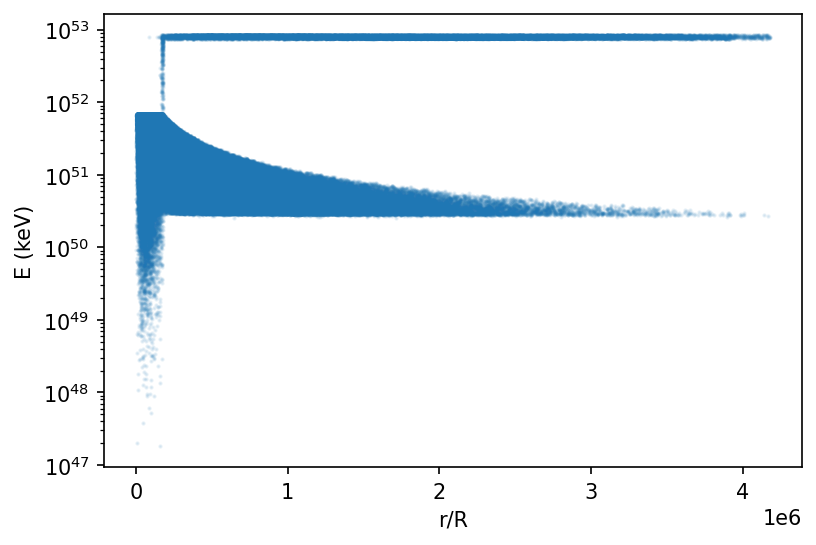

In [4]:
fig = plt.figure(dpi=150, facecolor='w')
ax = fig.add_subplot(111)

scatter = ax.scatter(np.array(ejecta_energy_r)/np.max(model.v_outer.value), np.array(ejecta_energy), s=1, alpha=0.1)
ax.set_xlabel("r/R")
ax.set_ylabel("E (keV)")
ax.semilogy();

## Interactions binned by radius

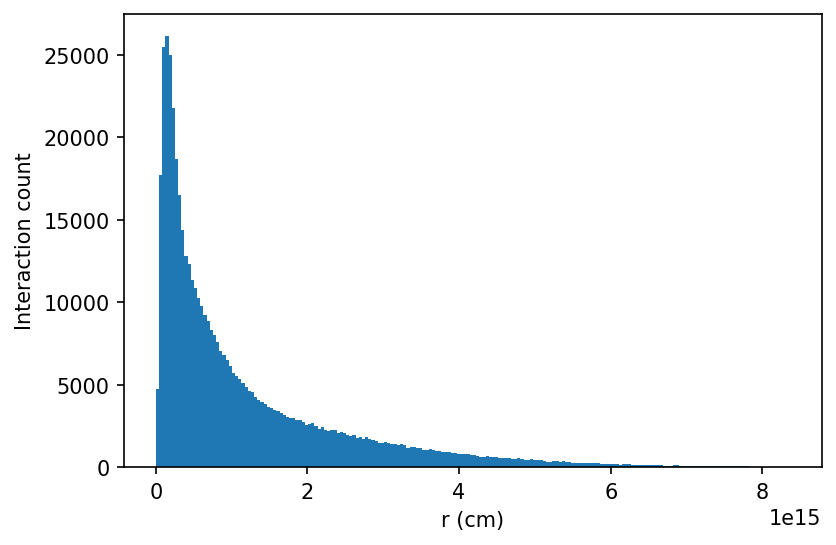

In [5]:
fig = plt.figure(dpi=150, facecolor='w')
ax = fig.add_subplot(111)
ax.hist(np.array(ejecta_energy_r), bins=200)
#ax.set_xlim(0, 1)
ax.set_xlabel("r (cm)")
ax.set_ylabel("Interaction count");

## Density Profile

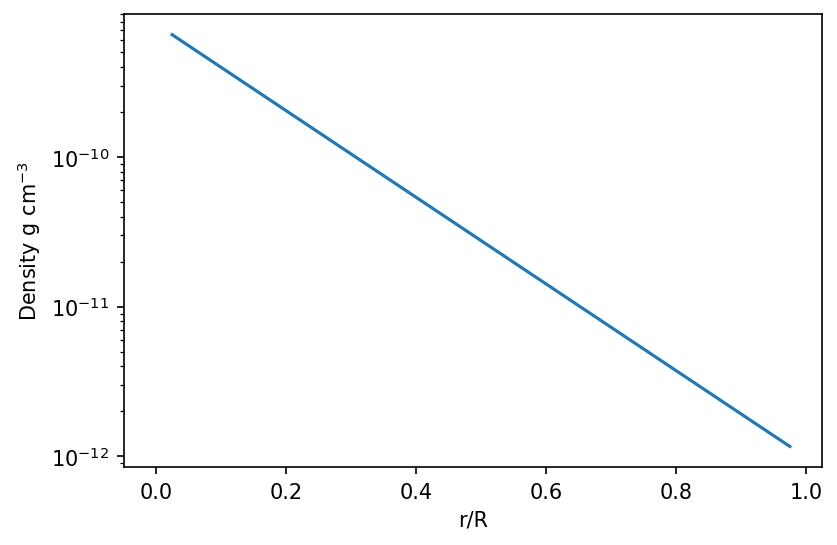

In [6]:
fig = plt.figure(dpi=150, facecolor='w')
plt.semilogy(model.r_middle/np.max(model.r_outer), model.density)
plt.plot(0,0)
plt.ylabel("Density g cm$^{-3}$")
plt.xlabel("r/R");

## Fraction of energy escaping from the ejecta

In [7]:
np.sum(np.sum(escape_energy) / (np.sum(escape_energy) + np.sum(energy_df)))

1.657117395460646e-53

## Spectrum of escape energy at the final time step

/home/afullard/tardis/tardis/energy_input/energy_source.py:250: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(


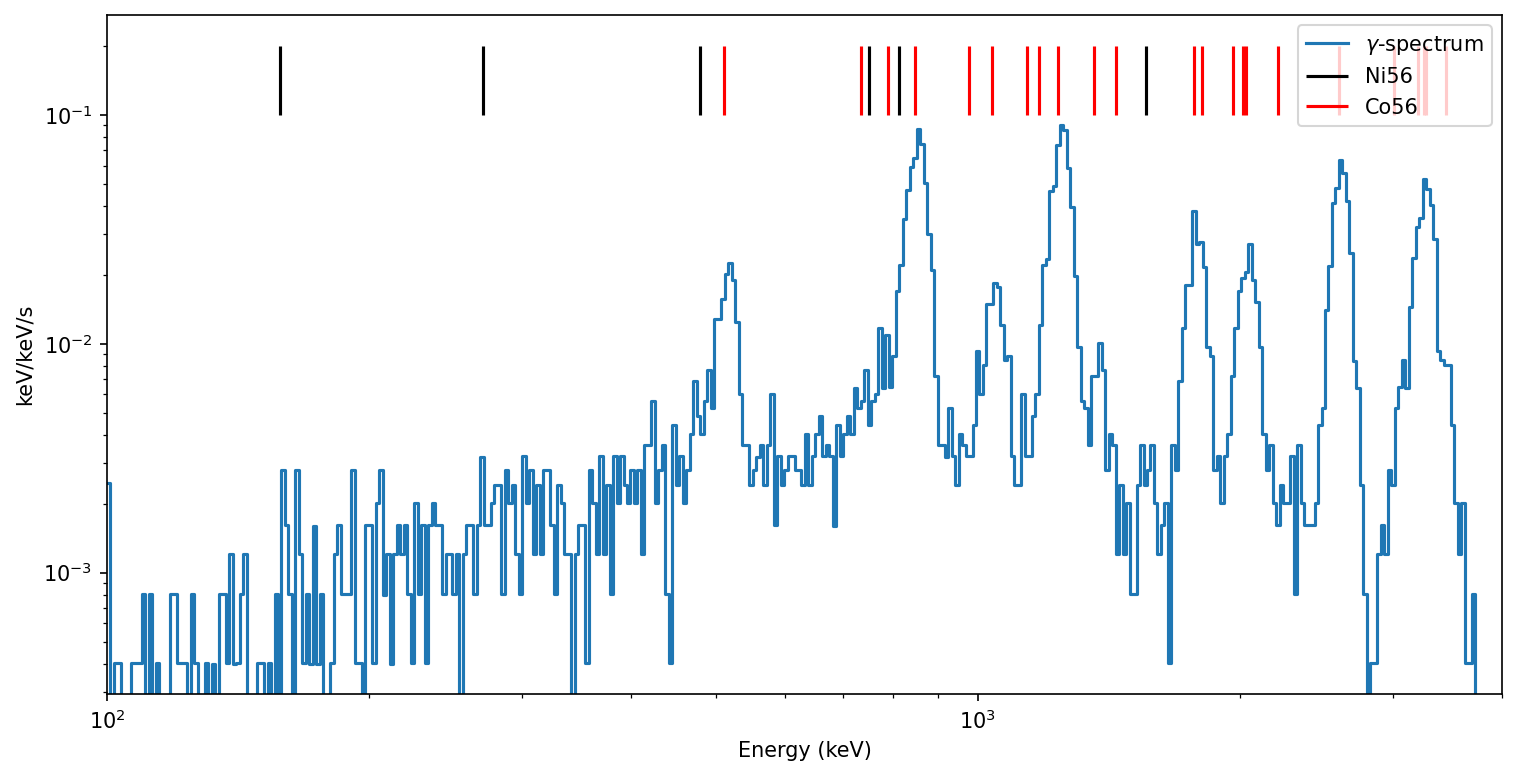

In [8]:
from tardis.energy_input.energy_source import read_artis_lines

ni56_lines = read_artis_lines("ni56", "~/Downloads/tardisnuclear/")
co56_lines = read_artis_lines("co56", "~/Downloads/tardisnuclear/")

plt.figure(figsize=(12, 6), dpi=150)
plt.step(escape_energy.index, escape_energy.iloc[:,49], label="$\gamma$-spectrum", where="post")
plt.xlabel("Energy (keV)")
plt.ylabel("keV/keV/s");
plt.loglog()
plt.xlim(100, 4000)
#plt.ylim(0.01, 100)
plt.vlines(ni56_lines.energy*1000, 0.1, 0.2, color="k", label="Ni56")
plt.vlines(co56_lines.energy*1000, 0.1, 0.2, color="r", label="Co56")
plt.legend()

## Energy deposition rate

Dataframe index is the radial grid location. Columns are time steps in seconds

In [9]:
energy_df

,1.728000e+05,1.842903e+05,1.965447e+05,2.096139e+05,2.235522e+05,2.384173e+05,2.542708e+05,2.711786e+05,2.892106e+05,3.084416e+05,...,2.269320e+06,2.420218e+06,2.581151e+06,2.752784e+06,2.935830e+06,3.131048e+06,3.339247e+06,3.561290e+06,3.798098e+06,4.050652e+06
0,1.294021e+54,1.114055e+53,1.099417e+53,1.145196e+53,6.985992e+52,1.559680e+53,1.132561e+53,1.150313e+53,1.245701e+53,9.349474e+52,...,2.785625e+52,2.011481e+52,9.433285e+51,1.291291e+52,1.496113e+52,1.443419e+52,1.065273e+52,1.076108e+52,8.903642e+51,7.441180e+51
1,6.424030e+54,6.521538e+53,6.970475e+53,7.781927e+53,7.466519e+53,6.541897e+53,5.479004e+53,6.608852e+53,6.894159e+53,5.724835e+53,...,1.220006e+53,1.153451e+53,1.189081e+53,9.767378e+52,8.049019e+52,7.613144e+52,7.005247e+52,6.722733e+52,5.885149e+52,4.869317e+52
2,1.243092e+55,1.451440e+54,1.374568e+54,1.127461e+54,1.336598e+54,1.147720e+54,1.335489e+54,1.271224e+54,1.320112e+54,1.230945e+54,...,2.390324e+53,2.262535e+53,2.054400e+53,1.968436e+53,1.732775e+53,1.515853e+53,1.384603e+53,1.369447e+53,1.254276e+53,1.073970e+53
3,1.761313e+55,1.947755e+54,1.776917e+54,2.060552e+54,1.837025e+54,1.753145e+54,1.897809e+54,1.803495e+54,1.619915e+54,1.585062e+54,...,3.530774e+53,3.016611e+53,2.881233e+53,2.731115e+53,2.656203e+53,2.203813e+53,2.107709e+53,1.972879e+53,1.734955e+53,1.516516e+53
4,2.102342e+55,2.162071e+54,2.327412e+54,2.192378e+54,2.078727e+54,2.054652e+54,2.242408e+54,2.069014e+54,2.146158e+54,1.916381e+54,...,4.199641e+53,3.751811e+53,3.333814e+53,3.298312e+53,3.041697e+53,2.856901e+53,2.335678e+53,2.191089e+53,2.081413e+53,1.814772e+53
5,2.285436e+55,2.416263e+54,2.363351e+54,2.352964e+54,2.514444e+54,2.235501e+54,2.234030e+54,2.134927e+54,2.190298e+54,2.176699e+54,...,4.436655e+53,4.012957e+53,3.805985e+53,3.386788e+53,3.075307e+53,2.952429e+53,2.516855e+53,2.483600e+53,2.149503e+53,1.824387e+53
6,2.186409e+55,2.531286e+54,2.084113e+54,2.371399e+54,2.487022e+54,2.301783e+54,2.128695e+54,2.420113e+54,2.125396e+54,1.977955e+54,...,4.286466e+53,3.963379e+53,3.759482e+53,3.214953e+53,3.278382e+53,2.808151e+53,2.282004e+53,2.329993e+53,2.011537e+53,1.819392e+53
7,2.089776e+55,2.020226e+54,2.197213e+54,2.312809e+54,2.420638e+54,2.115934e+54,2.120140e+54,2.133801e+54,1.971982e+54,1.998411e+54,...,3.765806e+53,3.486459e+53,3.189128e+53,2.849522e+53,2.685297e+53,2.477824e+53,2.235941e+53,2.006410e+53,1.797902e+53,1.550234e+53
8,1.931558e+55,2.330897e+54,2.118056e+54,2.095729e+54,1.970187e+54,2.023845e+54,2.044720e+54,1.965058e+54,1.777854e+54,1.892962e+54,...,3.575854e+53,3.167847e+53,2.871783e+53,2.662004e+53,2.240634e+53,1.931387e+53,1.750666e+53,1.699308e+53,1.386791e+53,1.182158e+53
9,1.733628e+55,1.712577e+54,1.776412e+54,1.912292e+54,1.815523e+54,1.761190e+54,1.674737e+54,1.651097e+54,1.734570e+54,1.612256e+54,...,2.887335e+53,2.555411e+53,2.254319e+53,1.910137e+53,1.931402e+53,1.582912e+53,1.442403e+53,1.295965e+53,1.114299e+53,9.479074e+52


## Energy deposition rate versus radius at time_explosion

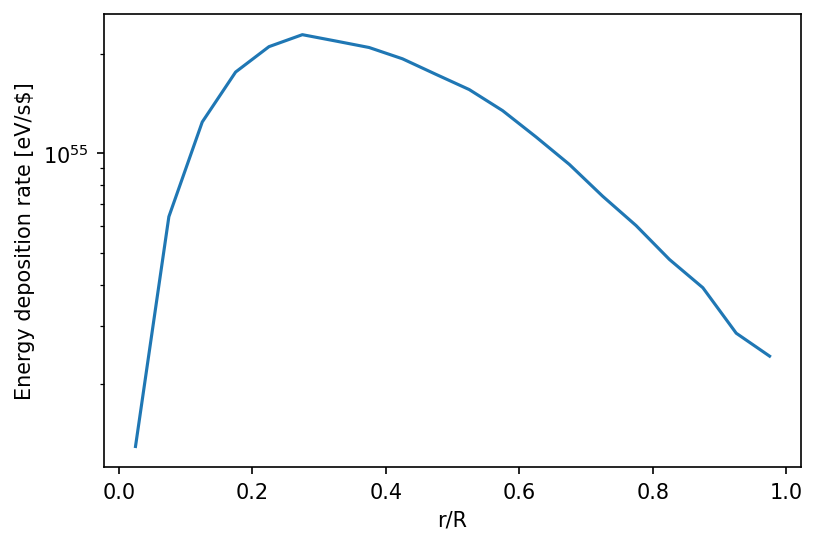

In [10]:
fig = plt.figure(dpi=150, facecolor='w')
plt.semilogy(model.v_middle/np.max(model.v_outer), energy_df.iloc[:, 0])
plt.xlabel("r/R")
plt.ylabel("Energy deposition rate [eV/s$]");

## Energy Deposition rate versus time compared to the analytic estimate

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.7, 1.1)

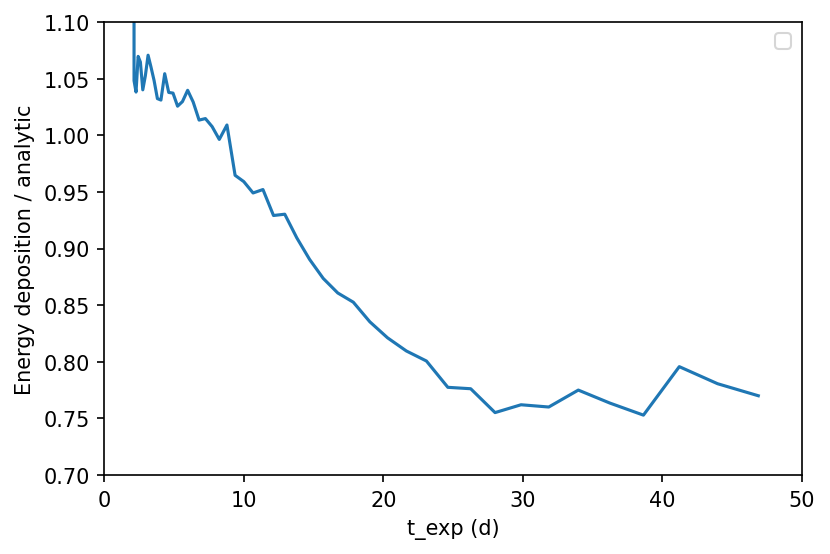

In [11]:
energy = energy_df.T.sum(axis=1) * u.eV.to('erg')

def analytic_estimate(t):
    return 0.6 * (0.97 * (1 - np.exp(-(40 / t)**2)) + 0.03) * (6.45 * np.exp(-t/8.8) + 1.45 * np.exp(-t/111.3)) * 1e43

t_tardis = energy.index * u.s.to('d')

plt.figure(dpi=150)
plt.plot(t_tardis, energy / analytic_estimate(t_tardis), "-")
plt.xlabel("t_exp (d)")
plt.ylabel("Energy deposition / analytic")
plt.legend()
plt.xlim(0, 50)
plt.ylim(0.7, 1.1)
